<a href="https://colab.research.google.com/github/kaitken17/colab_stuff/blob/master/large_learning_rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Core Code

In [95]:
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import timeit
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

USE_CUDA = False
use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device:', device)

Version 1.6.0+cu101
CUDA enabled: True
Using device: cpu


#### Network Definition

In [115]:
class fc_net(nn.Module):
    def __init__(self, network_params):
        super().__init__()
        self.width = network_params['width']
        self.length = network_params['length']
        self.input_dim = network_params['input_dim']
        self.activation = network_params['activation']
        self.bias = network_params['bias']
      
        self.fc_u = nn.Linear(self.input_dim, self.width, bias=self.bias)
        self.fc_v = nn.Linear(self.width, 1, bias=self.bias)

        # Initializes weights to N(0,1) (default is Xavier)
        nn.init.normal_(self.fc_u.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.fc_v.weight, mean=0.0, std=1.0)
        if self.bias:
            nn.init.normal_(self.fc_u.bias, mean=0.0, std=np.sqrt(self.width))
            nn.init.normal_(self.fc_v.bias, mean=0.0, std=np.sqrt(self.width))
        
        if self.length > 1:
            self.fc_w1 = nn.Linear(self.width, self.width, bias=self.bias)
            nn.init.normal_(self.fc_w1.weight, mean=0.0, std=1.0)
            if self.bias:
                nn.init.normal_(self.fc_w1.bias, mean=0.0, std=np.sqrt(self.width))
        if self.length > 2:
            self.fc_w2 = nn.Linear(self.width, self.width, bias=self.bias)
            nn.init.normal_(self.fc_w2.weight, mean=0.0, std=1.0)
            if self.bias:
                nn.init.normal_(self.fc_w2.bias, mean=0.0, std=self.np.sqrt(self.width))
        
        if self.activation == 'Identity':
            self.act = nn.Identity()
        elif self.activation == 'ReLU':
            self.act = nn.ReLU()
        elif self.activation == 'Tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError('Activation not implemented!')
        # self.act2 = nn.Identity()

    def forward(self, x):
        preact1 = 1 / np.sqrt(self.input_dim) * self.fc_u(x)
        postact1 = self.act(preact1)
        # x = self.act2(1 / np.sqrt(self.input_dim) * x)
        if self.length == 1:
            out = self.fc_v(postact1)
            hl_vals = [preact1, postact1]
        elif self.length > 1:
            preact2 = 1 / np.sqrt(self.width) * self.fc_w1(postact1)
            postact2 = self.act(preact2)
            # x = self.act2(1 / np.sqrt(self.width) * x)

            out = self.fc_v(postact2)
            hl_vals = [preact1, postact1, preact2, postact2]
        if self.length > 2:
            preact2 = 1 / np.sqrt(self.width) * self.fc_w1(postact1)
            postact2 = self.act(preact2)
            preact3 = 1 / np.sqrt(self.width) * self.fc_w2(postact2)
            postact3 = self.act(preact3)

            out = self.fc_v(postact3)
            hl_vals = [preact1, postact1, preact2, postact2, preact3, postact3]
                
        return 1 / np.sqrt(self.width) * out, hl_vals

    def get_params(self):
      if self.length == 1:
        return self.fc_u, self.fc_v
      else:
        raise NotImplementedError('Not implemeneted beyond length 1')

    def set_params(self, params):
      if self.length == 1:
        u_layer, v_layer = params
        self.fc_u.weight.data = torch.tensor(u_layer.reshape(self.width, self.input_dim))
        self.fc_v.weight.data = torch.tensor(v_layer.reshape(1, self.width))
        if self.bias:
          raise NotImplementedError('Not implemeneted for bias')
      else:
        raise NotImplementedError('Not implemeneted beyond length 1')

#### NTK Calculation

In [97]:
def ntk_auto(x, net):
  n_train = x.shape[0]
  ntk_val = np.zeros((n_train, n_train))

  GRAD_FIRST = True
  
  if GRAD_FIRST: # Calculates all gradients first, this might not work for large datasets
    outs = []
    grads = []
    for sample in range(x.size()[0]): # iterate over batch index
      out_for_sample, _ = net(x[sample,:])
      outs.append(out_for_sample)
      
      grads_for_sample = []
      for param_it in range(len(list(net.parameters()))):
        if list(net.parameters())[param_it].requires_grad: # only accesses gradients if they are calculated
          grad_val = torch.flatten(torch.autograd.grad(out_for_sample, list(net.parameters())[param_it], retain_graph=True)[0])
          grads_for_sample.append(grad_val)
      grads.append(grads_for_sample)
        
      # Calculation of ntk using gradients
    for sample1 in range(0, x.size()[0]): # iterate over batch index
      out1 = outs[sample1]
      for sample2 in range(0, x.size()[0]):
        out2 = outs[sample2]
        
        if sample1 > sample2: # NTK is symmetric, so doesn't recalculate these
          ntk_val[sample1][sample2] = ntk_val[sample2][sample1]
        else:
          for param_it in range(len(list(net.parameters()))):
            if list(net.parameters())[param_it].requires_grad: # only adds if gradient is calculated
              grads1 = grads[sample1][param_it]
              grads2 = grads[sample2][param_it]
              ntk_val[sample1][sample2] += torch.matmul(grads1, grads2).cpu().data.numpy()
  
  else: # Calculate gradients in real time, this is less efficient
    for sample1 in range(0, x.size()[0]): # iterate over batch index
      out1, _ = net(x[sample1,:])
      for sample2 in range(0, x.size()[0]):
        out2, _ = net(x[sample2,:])

        if sample1 > sample2: # NTK is symmetric, so doesn't recalculate these
          ntk_val[sample1][sample2] = ntk_val[sample2][sample1]
        else:
          for param_it in range(len(list(net.parameters()))):
            grads1 = torch.autograd.grad(out1, list(net.parameters())[param_it], retain_graph=True)
            grads2 = torch.autograd.grad(out2, list(net.parameters())[param_it], retain_graph=True)
            ntk_val[sample1][sample2] += torch.matmul(torch.flatten(grads1[0]),torch.flatten(grads2[0])).cpu().data.numpy()

  ntk_val = 1/n_train * ntk_val

  return ntk_val

#### Training

In [98]:
def train(train_data, train_params, network_params):
  """ Runs a single training example """
  
  # Unpacks train_data
  X, y = train_data[:][0], train_data[:][1]
  # Unpacks training parameters
  lr_init = train_params['lr']
  epochs = train_params['epochs']
  loss_type = train_params['loss']
  batch_size = train_params['batch_size']
  var_lr = train_params['var_lr']
  # Unpacks network parameters
  length = network_params['length']
  width = network_params['width']
  input_dim = network_params['input_dim']

  n_train = train_data[:][0].shape[0]
  steps = int(n_train/batch_size) * epochs

  # Values to be tracked during training
  f_trial = np.zeros((steps, n_train))
  ntk_trial  = np.zeros((steps, n_train, n_train))
  loss_trial  = np.zeros((steps))
  lr_trial  = np.zeros((steps))
  dead_neuron_trial  = np.zeros((length, steps))
  dead_neuron_idx = np.zeros((length, width))
  align_trial  = np.zeros((steps, length+1))
  initial_state_trial = np.zeros((2, width))

  net =  fc_net(network_params)

  if train_params['set_init_state']:
    init_state = train_params['init_state']
    net.set_params(init_state)
  if train_params['w_const']:
    params = list(net.fc_u.parameters()) + list(net.fc_v.parameters())
    optimizer = optim.SGD(params, lr=lr_init)
  else:
    optimizer = optim.SGD(net.parameters(), lr=lr_init)

  net = net.to(device)

  for epoch in range(epochs):
    for batch in range(0, len(X), batch_size):
                
      step = int(n_train/batch_size) * epoch + batch
                
      batch_X = X[batch:batch + batch_size]
      batch_y = y[batch:batch + batch_size]
                                   
      net.zero_grad()

      output, act_vals = net(batch_X)

      f = output.data.cpu().numpy()[:,0]

      # Finds losses and dL/df (lprime) for various losses
      if loss_type == 'MSE':
          y_val = [val[0] for val in batch_y.cpu().data.numpy()]
          # MSE loss is (f(x)-y)^2 so need np.sqrt(2) in order to map to 1/2*(f(x)-y)^2
          loss = F.mse_loss(1/np.sqrt(2)*output, 1/np.sqrt(2)*batch_y, reduction='mean')
          lprime = 1/n_train * (f-y_val)
      elif loss_type == 'XE':
          y_val = batch_y.cpu().data.numpy()[:]
          # Effectively turns single-output cross entropy into two-output for softmax
          out = torch.stack([-1/2 * output.view(batch_size), 1/2 * output.view(batch_size)], dim=1)
          loss = F.cross_entropy(out, batch_y)
          lprime = np.zeros(batch_size)
          for sample in range(batch_size):
              out = f[sample]
              if batch_y[sample] == 0:
                  lprime[sample] = 1/n_train * 1/(1+np.exp(-out))
              elif batch_y[sample] == 1:
                  lprime[sample] = -1/n_train * 1/(1+np.exp(out))
          lprime_mse = 1/n_train * (f-y_val)
      else:
          raise ValueError("Loss not implemented")

      loss.backward()

      ntk_array = ntk_auto(X, net) 
      
      with torch.no_grad(): # doesn't track gradients through below calculations
        # Dead Neuron Calculation
        if network_params['activation'] == 'ReLU':
          dead_neuron_trial[:,step], dead_neuron_idx = dead_neuron_calcs(act_vals, net, train_params, network_params)
        if epoch == 0:
          initial_state_trial = np.copy(initial_state_vals(act_vals, net, train_params, network_params))
          if length > 1:
            initial_preacts = np.copy(initial_state_vals_mod(act_vals, net, train_params, network_params))
          else:
            initial_preacts = 0
        # align_trial[step] = alignments_calc(act_vals, net, train_params, network_params)
      # Variable Learning Rate
      if var_lr:
        if loss_type == 'XE':
          # Amount the learning_rate should be adjusted
          val = np.sum(lprime_mse)/np.sum(lprime)
          lr_trial[step] = adjust_learning_rate(optimizer, lr_init, val)
        else:
          raise NotImplementedError('Variable LR for loss type not implemented.')
      else:
        lr_trial[step] = lr_init

      f_trial[step] = f
      ntk_trial[step] = ntk_array
      loss_trial[step] = loss

      # print(net.fc_w1.weight.data[:2])
      
      optimizer.step()
  
  train_trial_outs = {'f_trial': f_trial, 'ntk_trial': ntk_trial, 'loss_trial': loss_trial, 
                      'dead_neuron_trial': dead_neuron_trial, 'initial_state': initial_state_trial,
                      'dead_neuron_idx': dead_neuron_idx, 'align_trial': align_trial, 'initial_preact': initial_preacts,
                      'lr_trial': lr_trial,}

  return train_trial_outs

def train_trials(train_data, train_params, network_params):
  """ Runs many training examples """

  n_train = train_data[:][0].shape[0]
  trials = train_params['trials']
  epochs = train_params['epochs']
  batch_size = train_params['batch_size']
  steps = int(n_train/batch_size) * epochs

  length = network_params['length']
  width = network_params['width']

  fs = np.zeros((trials, steps, n_train))
  ntks = np.zeros((trials, steps, n_train, n_train))
  losses = np.zeros((trials, steps))
  lrs = np.zeros((trials, steps))
  dead_neurons = np.zeros((trials, length, steps))
  align = np.zeros((trials, steps, length+1))
  initial_states = [] # only keeps u and v inits
  dead_neuron_idxs = []
  f0s = []
  lam0s = []
  rand_preact0 = []

#     for trial in tqdm(range(TRIALS)):
  for trial in range(trials):
    train_trial_outs = train(train_data, train_params, network_params)
    fs[trial] = train_trial_outs['f_trial']
    ntks[trial] = train_trial_outs['ntk_trial']
    losses[trial] = train_trial_outs['loss_trial']
    lrs[trial] = train_trial_outs['lr_trial']
    dead_neurons[trial] = train_trial_outs['dead_neuron_trial']
    align[trial] = train_trial_outs['align_trial']
    
    initial_states.append(train_trial_outs['initial_state'])
    dead_neuron_idxs.append(train_trial_outs['dead_neuron_idx'])
    f0s.append(train_trial_outs['f_trial'][0])
    eig0s = np.linalg.eigvals(train_trial_outs['ntk_trial'][0])
    lam0s.append(np.amax(eig0s))
    rand_preact0.append(train_trial_outs['initial_preact'])

  # Dictionary to hold various training parameters    
  train_outputs ={
   'fs': 1 / trials * np.sum(np.abs(fs), axis=0),
    'ntks': 1 / trials * np.sum(ntks, axis=0),
    'losses': 1 / trials * np.sum(losses, axis=0),
    'lrs': 1 / trials * np.sum(lrs, axis=0),
    'dead_neurons': 1 / trials * np.sum(dead_neurons, axis=0),
    'align': 1 / trials * np.sum(align, axis=0),
    'initial_states': initial_states,
    'dead_neuron_idx': dead_neuron_idxs,
    'f0s': f0s,
    'lam0s': lam0s,
    'preact0': rand_preact0,
  }

  return train_outputs

In [126]:
test_matrix = np.asarray([[1,1],[1,1]])
e_vals, e_vecs = np.linalg.eig(test_matrix)
print(e_vals[0])
print(e_vecs[0])

2.0
[ 0.70710678 -0.70710678]


#### Other Functions

In [99]:
def default_params(train_data, train_params, network_params, result_params):
  """ Sets the defaults of many parameters if not specified"""
  if 'batch_size' not in train_params: train_params['batch_size'] = train_data[0].shape[0]
  if 'var_lr' not in train_params: train_params['var_lr'] = False
  if 'set_init_state' not in train_params: train_params['set_init_state'] = False

  if 'activation' not in network_params: network_params['activation'] = 'Identity'
  if 'bias' not in network_params: network_params['bias'] = False

  if 'plots' not in result_params: result_params['plots'] = []
  if 'save_data' not in result_params: result_params['save_data'] = False
  if 'file_name' not in result_params: result_params['file_name'] = ''
  if 'override' not in result_params: result_params['override'] = False

  return train_params, network_params, result_params

def dead_neuron_calcs(act_vals, net, train_params, network_params):

  width = network_params['width']
  length = network_params['length']
  input_dim = network_params['input_dim']

  batch_size = train_params['batch_size']
  if batch_size > 1:
    # Need to redefine what it means to be alive for more than one training set
    raise NotImplementedError

  alive_idxs = np.zeros((length, width))
  num_alive = np.zeros((length))

  preact1 = act_vals[0].data.cpu().numpy().flatten()

  alive_idxs[0] = [1 if preact > 0 else 0 for preact in preact1]
  num_alive[0] = np.sum(alive_idxs[0])

  if length > 1:
    preact2 = act_vals[2].data.cpu().numpy().flatten()
    
    alive_idxs[1] = [1 if preact > 0 else 0 for preact in preact2]
    num_alive[1] = np.sum(alive_idxs[1])

  if length > 2:
    preact3 = act_vals[4].data.cpu().numpy().flatten()
    
    alive_idxs[2] = [1 if preact > 0 else 0 for preact in preact3]
    num_alive[2] = np.sum(alive_idxs[2])
  
  perc_dead = [1- 1/(width * batch_size) * alive for alive in num_alive]

  return perc_dead, alive_idxs

def alignments_calc(act_vals, net, train_params, network_params):
  """ Calculates how much a weight vector/matrix aligns with its update"""

  length = network_params['length']

  ui = net.fc_u.weight.data.cpu().numpy()[:,0]
  vi = net.fc_v.weight.data.cpu().numpy()[0]
  if length == 1:
      v_diff = np.abs(np.dot(vi,ui)/np.sqrt(np.dot(vi,vi) * np.dot(ui,ui)))
      u_diff = np.abs(np.dot(ui,vi)/np.sqrt(np.dot(vi,vi) * np.dot(ui,ui)))

      align_angles = [v_diff, u_diff]
  elif length == 2:
      preact1 = act_vals[0].data.cpu().numpy().flatten()
      preact2 = act_vals[2].data.cpu().numpy().flatten()
      postact2 = act_vals[3].data.cpu().numpy().flatten()

      wij = net.fc_w1.weight.data.cpu().numpy()
      
      wu = np.matmul(wij, ui)
      vw = np.matmul(vi, wij)
      v_diff = np.abs(np.dot(vi,postact2)/np.sqrt(np.dot(vi,vi) * np.dot(postact2, postact2)))
      u_diff = np.abs(np.dot(vw,ui)/np.sqrt(np.dot(vw,vw) * np.dot(ui,ui)))
      
      w_flat = wij.flatten()
      vu_flat = np.outer(vi,ui).flatten()
      w_diff = np.abs(np.dot(vu_flat,w_flat)/np.sqrt(np.dot(vu_flat,vu_flat) * np.dot(w_flat,w_flat)))
      
      align_angles = [v_diff, w_diff, u_diff]
      # ntk_comp_mags[trial][step] = [1/(WIDTH**2)*np.dot(wu,wu), 1/(WIDTH**2)*np.dot(vi,vi)*np.dot(ui,ui), 
      #                               1/(WIDTH**2)*np.dot(vw,vw)]
      # weight_mags[trial][step] = [np.sqrt(np.dot(vi,vi)), np.sqrt(1/WIDTH*np.dot(w_flat,w_flat)), np.sqrt(np.dot(ui,ui)),
      #                             np.sqrt(1/WIDTH*np.dot(wu, wu)), np.sqrt(1/WIDTH*np.dot(vw, vw))]
  
  return align_angles

def initial_state_vals(act_vals, net, train_params, network_params):

  width = network_params['width']
  length = network_params['length']

  if length == 1:
    return np.array([net.fc_u.weight.data.cpu().view(width).numpy(), net.fc_v.weight.data.cpu().view(width).numpy()])
  elif length ==2:
    # u_mult = np.zeros(width)
    
    # preact2 = np.copy(act_vals[2].data.cpu().numpy()).flatten()
    # alive2 = [1 if preact > 0 else 0 for preact in preact2]
    # vi = np.copy(net.fc_v.weight.data.cpu().view(width).numpy())
    # wij = np.copy(net.fc_w1.weight.data.cpu().numpy())
    # v_alive = np.array([v_value * alive for v_value, alive in zip(vi, alive2)])
    # u_mult = np.copy(np.matmul(v_alive, wij))
    # # u_mult = np.copy(np.matmul(vi, wij))

    # return np.array([net.fc_u.weight.data.cpu().view(width).numpy(), u_mult])

    v_mult = np.zeros(width)
    
    preact2 = np.copy(act_vals[2].data.cpu().numpy())
    v_mult = preact2

    return np.array([v_mult, net.fc_v.weight.data.cpu().view(width).numpy()])


def initial_state_vals_mod(act_vals, net, train_params, network_params):

  width = network_params['width']
  length = network_params['length']

  random_neuron_idx = 5

  v_mult = np.zeros(width)

  preact1 = act_vals[0].data.cpu().numpy().flatten()
  preact2 = np.copy(act_vals[2].data.cpu().numpy().flatten())

  alive1 = [1 if preact > 0 else 0 for preact in preact1]
  wij = np.copy(net.fc_w1.weight.data.cpu().numpy())
  wij_alive = np.matmul(wij, alive1)

  return np.array(preact2[random_neuron_idx])

def adjust_learning_rate(optimizer, lr_init, val):
    """Sets the learning rate to the initial LR decayed by val"""
    lr = lr_init * val
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

### Experiments

#### Run Multiple Learning Rates

In [100]:
def test_multiple_lrs(train_data, train_params, network_params, result_params):
  """ Runs training trials for a variety of learning_rates """
  
  results = {'fs': [], 'lams': [], 'ntks': [], 'losses': [], 'lrs': [], 'dead_neurons': [], 'lr_epochs': [], 
             'initial_states': [], 'dead_neuron_idx': [], 'f0s': [], 'lam0s': [], 'preact0': [],}

  lr_vals = train_params['lr_vals']

  for lr_idx in range(len(lr_vals)):
    if train_params['physical_time']:
        epochs_val = int(np.ceil(train_params['physical_time_cap']/lr_vals[lr_idx]))
    else:
        epochs_val = train_params['epochs']
    
    steps_val = epochs_val * train_data[:][0].shape[0]/train_params['batch_size']
    results['lr_epochs'].append(epochs_val)

    print("Running LR:", lr_vals[lr_idx], " for ", steps_val, ' steps (', epochs_val, " epochs).")
    
    train_params['lr'] = lr_vals[lr_idx]
    train_outputs = train_trials(train_data, train_params, network_params)

    results['fs'].append(train_outputs['fs'])
    results['ntks'].append(train_outputs['ntks'])
    results['losses'].append(train_outputs['losses'])
    results['lrs'].append(train_outputs['lrs'])
    results['dead_neurons'].append(train_outputs['dead_neurons'])
    results['initial_states'].append(train_outputs['initial_states'])
    results['dead_neuron_idx'].append(train_outputs['dead_neuron_idx'])
    results['f0s'].append(train_outputs['f0s'])
    results['lam0s'].append(train_outputs['lam0s'])
    results['preact0'].append(train_outputs['preact0'])
      
    # Calculates properties of the ntk and extracts first f component
    try:
      eigs = np.linalg.eigvals(train_outputs['ntks'])
      results['lams'].append(np.amax(eigs, axis=1))
    except:
      print('Error while trying to calculated lambda values.')
      results['lams'].append(['nan'])
    

  # Analyze dead neurons
  # analyze_dead_neurons(results, train_params, network_params, result_params)
  # Plots the data
  if len(result_params['plots']) > 0:
    plot_results(results, train_params, network_params, result_params)

  return results

##### Dead Neuron Analysis

In [101]:
def analyze_dead_neurons(results, train_params, network_params, result_params):
  for lr_idx in range(len(train_params['lr_vals'])):
    n_alive1 = []
    n_alive2 = []
    n_survive = 0
    for trial in range(train_params['trials']):
      n_alive1_trial = np.sum(results['dead_neuron_idx'][lr_idx][trial][0])
      n_alive1.append(n_alive1_trial)
      n_alive2_trial = np.sum(results['dead_neuron_idx'][lr_idx][trial][1])
      n_alive2.append(n_alive2_trial)
      if n_alive2_trial > 0: n_survive += 1

    print('LR', train_params['lr_vals'][lr_idx],' - perc survive:', n_survive/train_params['trials'])
    print('LR', train_params['lr_vals'][lr_idx],' - # neurons alive:', [(n_alive1[x], n_alive2[x]) for x in list(range(len(n_alive1))) if n_alive2[x] > 0])

#### Neuron Survival Tests

In [102]:
def neuron_surivival(train_data, train_params, network_params, result_params):
  """ Analyzes what makes a network's neurons survive for a sngle learning rate """
  
  results = {'fs': [], 'lams': [], 'ntks': [], 'losses': [], 'dead_neurons': [], 'lr_epochs': [], 'initial_states': [],
             'dead_neuron_idx': [], 'f0s': [], 'lam0s': []}

  lr_vals = train_params['lr_vals']
  if len(lr_vals) > 1:
    raise ValueError('Not implemented for multiple learning rates')
  train_params['lr'] = lr_vals[0]

  trials = train_params['trials']
  length = network_params['length']

  plt.figure(figsize=[12.8, 9.6])

  plt.suptitle(train_params['loss'] + ' Loss - ' + network_params['activation'] + ' L=' + str(network_params['length']) +
               ' Model, BIAS: ' + str(network_params['bias'] ), fontsize=16)
  plt.figtext(.5,.925,'LR:' + str(train_params['lr']) + ', Width: ' + str(network_params['width'] ) + ', Trials: ' + str(train_params['trials']) + ', Training Ex: ' + str()
              + str(train_params['n_train']), fontsize=12, ha='center')
  
  ax1 = plt.subplot('221')
  ax2 = plt.subplot('222')
  ax3 = plt.subplot('223')
  ax4 = plt.subplot('224')
  ax1.set_xlabel('Step')
  ax2.set_xlabel('Step')
  ax3.set_xlabel('Step')
  ax4.set_xlabel('Step')
  ax1.set_ylabel('|f|')
  ax2.set_ylabel('|f|')
  ax3.set_ylabel('HL 1 Dead Neuron Perc')
  ax4.set_ylabel('Lambda')
  x_plot = list(range(train_params['epochs']))

  # ax1.set_ylim([0, 50])
  # ax2.set_ylim([0, 10])
  ax2_limit = 11
  ax3.axhline(1, color='k', linestyle='--')
  # ax4.set_ylim([0, 1.1])
  ax4.axhline(1, color='k', linestyle='--')

  for trial in range(trials):
    train_trial_outs = train(train_data, train_params, network_params)
    print('Number of alive neurons:', np.sum(train_trial_outs['dead_neuron_idx']))
    
    eigs = np.linalg.eigvals(train_trial_outs['ntk_trial'])
    lam = np.amax(eigs, axis=1)

    plt_color = 'b' if np.sum(train_trial_outs['dead_neuron_idx']) > 0 else 'r'
    
    # ax1.plot(x_plot, train_trial_outs['f_trial'], c=plt_color)
    ax1.plot(x_plot, np.abs(train_trial_outs['f_trial']), c=plt_color)
    ax2.plot(x_plot[:ax2_limit], train_trial_outs['f_trial'][:ax2_limit], c=plt_color)
    ax3.plot(x_plot, train_trial_outs['dead_neuron_trial'][length-1], c=plt_color)
    ax4.plot(x_plot, lam, c=plt_color)
    # ax4.plot(x_plot, [x[0] for x in train_trial_outs['align_trial']], c=plt_color)
    # ax4.plot(x_plot, train_trial_outs['dead_neuron_trial'][0], c=plt_color)

  plt.show()



#### Variable LR Tests

In [103]:
def train_trials_same_init(train_data1, train_data2, train_params1, train_params2, network_params):
  """ Runs many training examples with different parameters, but uses the same inits for all trials """

  if train_params1['trials'] != train_params2['trials']:
    raise NotImplementedError('Need same number of trials')
  trials = train_params1['trials']

  length = network_params['length']
  width = network_params['width']

  n_train1 = train_data1[:][0].shape[0]
  steps1 = int(n_train1/train_params1['batch_size']) * train_params1['epochs']
  fs1 = np.zeros((trials, steps1, n_train1))
  ntks1 = np.zeros((trials, steps1, n_train1, n_train1))
  losses1 = np.zeros((trials, steps1))
  lrs1 = np.zeros((trials, steps1))

  n_train2 = train_data2[:][0].shape[0]
  steps2 = int(n_train2/train_params2['batch_size']) * train_params2['epochs']
  fs2 = np.zeros((trials, steps2, n_train2))
  ntks2 = np.zeros((trials, steps2, n_train2, n_train2))
  losses2 = np.zeros((trials, steps2))
  lrs2 = np.zeros((trials, steps2))

  for trial in range(trials):
    train_trial_outs = train(train_data1, train_params1, network_params)
    fs1[trial] = train_trial_outs['f_trial']
    ntks1[trial] = train_trial_outs['ntk_trial']
    losses1[trial] = train_trial_outs['loss_trial']
    lrs1[trial] = train_trial_outs['lr_trial']

    train_params2['init_state'] = train_trial_outs['initial_state']
    
    train_trial_outs = train(train_data2, train_params2, network_params)
    fs2[trial] = train_trial_outs['f_trial']
    ntks2[trial] = train_trial_outs['ntk_trial']
    losses2[trial] = train_trial_outs['loss_trial']
    lrs2[trial] = train_trial_outs['lr_trial']

  # Dictionary to hold various training parameters    
  train_outputs1 ={
    'fs': 1 / trials * np.sum(np.abs(fs1), axis=0),
    'ntks': 1 / trials * np.sum(ntks1, axis=0),
    'losses': 1 / trials * np.sum(losses1, axis=0),
    'lrs': 1 / trials * np.sum(lrs1, axis=0),
  }

  train_outputs2 ={
   'fs': 1 / trials * np.sum(np.abs(fs2), axis=0),
    'ntks': 1 / trials * np.sum(ntks2, axis=0),
    'losses': 1 / trials * np.sum(losses2, axis=0),
    'lrs': 1 / trials * np.sum(lrs2, axis=0),
  }

  return train_outputs1, train_outputs2

def test_multiple_lrs_same_init(train_data1, train_data2, train_params1, train_params2, network_params, result_params):
  """ Runs training trials for a variety of learning_rates """
  
  results1 = {'fs': [], 'lams': [], 'ntks': [], 'losses': [], 'lrs': [], 'lr_epochs': []}
  results2 = {'fs': [], 'lams': [], 'ntks': [], 'losses': [], 'lrs': [], 'lr_epochs': []}

  if train_params1['lr_vals'] != train_params2['lr_vals']:
    raise NotImplementedError('Need same learning rates')

  lr_vals = train_params1['lr_vals']

  for lr_idx in range(len(lr_vals)):
    if train_params1['physical_time']:
        epochs_val = int(np.ceil(train_params['physical_time_cap']/lr_vals[lr_idx]))
    else:
        epochs_val = train_params['epochs']
    
    steps_val = epochs_val * train_data1[:][0].shape[0]/train_params1['batch_size']
    results1['lr_epochs'].append(epochs_val)
    results2['lr_epochs'].append(epochs_val)

    print("Running LR:", lr_vals[lr_idx], " for ", steps_val, ' steps (', epochs_val, " epochs).")
    
    train_params1['lr'] = lr_vals[lr_idx]
    train_params2['lr'] = lr_vals[lr_idx]
    train_outputs1, train_outputs2 = train_trials_same_init(train_data1, train_data2, train_params1, train_params2, network_params)

    results1['fs'].append(train_outputs1['fs'])
    results1['ntks'].append(train_outputs1['ntks'])
    results1['losses'].append(train_outputs1['losses'])
    results1['lrs'].append(train_outputs1['lrs'])

    results2['fs'].append(train_outputs2['fs'])
    results2['ntks'].append(train_outputs2['ntks'])
    results2['losses'].append(train_outputs2['losses'])
    results2['lrs'].append(train_outputs2['lrs'])
      
    # Calculates properties of the ntk and extracts first f component
    try:
      eigs1 = np.linalg.eigvals(train_outputs1['ntks'])
      results1['lams'].append(np.amax(eigs1, axis=1))
      eigs2 = np.linalg.eigvals(train_outputs2['ntks'])
      results2['lams'].append(np.amax(eigs2, axis=1))
    except:
      print('Error while trying to calculated lambda values.')
      results1['lams'].append(['nan'])
      results2['lams'].append(['nan'])

  return results1, results2

In [104]:
def compare_mse_and_xe(train_data, train_params, network_params, result_params):

  loss1_params = {'loss_type': 'MSE', 'var_lr': False}
  loss2_params = {'loss_type': 'XE', 'var_lr': True}

  compare_two_losses(train_data, loss1_params, loss2_params, train_params, network_params, result_params)

def compare_two_losses(train_data, loss1_params, loss2_params, train_params, network_params, result_params):
  """ Comapres two losses """
  
  X, y = train_data
  X_device = X.view(X.shape[0], network_params['input_dim']).to(device)
  
  train_params1 = train_params.copy()
  train_params2 = train_params.copy()
  
  # Loss 1
  train_params1['loss'] = loss1_params['loss_type']
  train_params1['var_lr'] = loss1_params['var_lr']
  train_params2['loss'] = loss2_params['loss_type']
  train_params2['var_lr'] = loss2_params['var_lr']
  train_params2['set_init_state'] = True

  if loss1_params['loss_type'] == 'MSE':
    y_device = y.view(y.shape[0], network_params['input_dim']).to(device)
  elif loss1_params['loss_type'] == 'XE':
    y_device = y.view(y.shape[0]).to(device)
  train_data1 = [X_device, y_device]

  if loss2_params['loss_type'] == 'MSE':
    y_device = y.view(y.shape[0], network_params['input_dim']).to(device)
  elif loss2_params['loss_type'] == 'XE':
    y_device = y.view(y.shape[0]).to(device)
  train_data2 = [X_device, y_device]
  
  _, _, temp_result_params = default_params(train_data1, {}, {}, {}) # Gets default result params

  print('Loss Type: {} / Variable Learning Rate: {}'.format(train_params1['loss'], train_params1['var_lr']))
  print('Loss Type: {} / Variable Learning Rate: {}'.format(train_params2['loss'], train_params2['var_lr']))

  results1, results2 = test_multiple_lrs_same_init(train_data1, train_data2, train_params1, train_params2, network_params, temp_result_params)

  #### Plotting Stuff ####

  plt.figure(figsize=[12.8, 9.6])

  colors = ['r', 'tab:orange', 'y', 'g', 'c', 'b',  'm', 'tab:Brown', 'k']

  # x Axis generation
  x_plot, x_label_str = x_plot_generation(results1, train_params)
  
  plt.suptitle(loss1_params['loss_type'] + 'and' + loss2_params['loss_type'] + ' Loss - ' + network_params['activation'] + 
               ' L=' + str(network_params['length']) + ' Model, BIAS: ' + str(network_params['bias'] ), fontsize=16)
  plt.figtext(.5,.925,'Width: ' + str(network_params['width'] ) + ', Trials: ' + str(train_params['trials']) + ', Training Ex: ' + str()
              + str(train_params['n_train']), fontsize=12, ha='center')
  
  sbpltnums = subplot_nums(3)

  lr_vals = train_params['lr_vals']

  ax1 = plt.subplot(sbpltnums[0])
#   ax1.set_ylim([0, 1])
  for lr_idx in range(len(lr_vals)):
    ax1.plot(x_plot[lr_idx], results1['fs'][lr_idx][:,0], c=colors[lr_idx], 
             label='{} ({})'.format(lr_vals[lr_idx], loss1_params['loss_type']))
    ax1.plot(x_plot[lr_idx], results2['fs'][lr_idx][:,0], c=colors[lr_idx], marker='o', linestyle='dashed', 
             label='{} ({})'.format(lr_vals[lr_idx], loss2_params['loss_type']))
  ax1.set_xlabel(x_label_str)
  ax1.set_ylabel('Loss')
  ax1.legend()

  ax2 = plt.subplot(sbpltnums[1])
#   ax2.set_ylim([-0.05, 0.25])
  for lr_idx in range(len(lr_vals)):
    ax2.plot(x_plot[lr_idx], results1['lams'][lr_idx], c=colors[lr_idx],
             label='{} ({})'.format(lr_vals[lr_idx], loss1_params['loss_type']))
    ax2.plot(x_plot[lr_idx], results2['lams'][lr_idx], c=colors[lr_idx], marker='o', linestyle='dashed',
             label='{} ({})'.format(lr_vals[lr_idx], loss2_params['loss_type']))
  ax2.set_xlabel(x_label_str)
  ax2.set_ylabel('Lambda')
  ax2.legend(lr_vals)

  ax3 = plt.subplot(sbpltnums[2])
#   ax1.set_ylim([0, 1])
  for lr_idx in range(len(lr_vals)):
    ax3.plot(x_plot[lr_idx], results1['lrs'][lr_idx], c=colors[lr_idx],
             label='{} ({})'.format(lr_vals[lr_idx], loss1_params['loss_type']))
    ax3.plot(x_plot[lr_idx], results2['lrs'][lr_idx], c=colors[lr_idx], marker='o', linestyle='dashed',
             label='{} ({})'.format(lr_vals[lr_idx], loss2_params['loss_type']))
  ax3.set_xlabel(x_label_str)
  ax3.set_ylabel('Learning Rate')
  ax3.legend(lr_vals)

#### Plots Data

In [105]:
def x_plot_generation(results, train_params):
  lr_vals = train_params['lr_vals']
  x_plot = []
  if train_params['physical_time']:
    x_label_str = 'Eta * Step'
    for lr_idx in range(len(lr_vals)):
      x_plot.append([lr_vals[lr_idx]*i for i in list(range(results['lr_epochs'][lr_idx]))])
  else:
    x_label_str = 'Step'
    for lr_idx in range(len(lr_vals)):
      x_plot.append(list(range(train_params['epochs'])))

  return x_plot, x_label_str
  
def plot_results(results, train_params, network_params, result_params):
  """ Plots all the things"""
  
  plots = result_params['plots']
  num_sub_figs = len(plots)
  lr_vals = train_params['lr_vals']
  length = network_params['length']

  sbpltnums = subplot_nums(num_sub_figs)
  if num_sub_figs > 4:
    plt.figure(figsize=[1.5* 12.8, 9.6])
  else:
    plt.figure(figsize=[12.8, 9.6])

  colors = ['r', 'tab:orange', 'y', 'g', 'c', 'b',  'm', 'tab:Brown', 'k']

  # x Axis generation
  x_plot, x_label_str = x_plot_generation(results, train_params)
  
  plt.suptitle(train_params['loss'] + ' Loss - ' + network_params['activation'] + ' L=' + str(network_params['length']) +
               ' Model, BIAS: ' + str(network_params['bias'] ), fontsize=16)
  plt.figtext(.5,.925,'Width: ' + str(network_params['width'] ) + ', Trials: ' + str(train_params['trials']) + ', Training Ex: ' + str()
              + str(train_params['n_train']), fontsize=12, ha='center')
  # plt.figtext(.5, .895, 'Batch size:' + str(BATCH_SIZE), fontsize=12, ha='center')

  subplot_count = 0
  # Loss vs step subplot
  if 'Loss' in plots: 
    ax1 = plt.subplot(sbpltnums[subplot_count])
  #   ax1.set_ylim([0, 1])
    for lr_idx in range(len(lr_vals)):
      ax1.plot(x_plot[lr_idx], results['losses'][lr_idx], c=colors[lr_idx], marker='o')
    ax1.set_xlabel(x_label_str)
    ax1.set_ylabel('Loss')
    ax1.legend(lr_vals)
    subplot_count += 1

  if 'LR' in plots: 
    ax8 = plt.subplot(sbpltnums[subplot_count])
  #   ax1.set_ylim([0, 1])
    for lr_idx in range(len(lr_vals)):
      ax8.plot(x_plot[lr_idx], results['lrs'][lr_idx], c=colors[lr_idx], marker='o')
    ax8.set_xlabel(x_label_str)
    ax8.set_ylabel('Learning Rate')
    ax8.legend(lr_vals)
    subplot_count += 1
  
  # Lambda vs step subplot
  if 'Lambda' in plots:
    ax2 = plt.subplot(sbpltnums[subplot_count])
  #   ax2.set_ylim([-0.05, 0.25])
    for lr_idx in range(len(lr_vals)):
      ax2.plot(x_plot[lr_idx], results['lams'][lr_idx], c=colors[lr_idx], marker='o')
    ax2.set_xlabel(x_label_str)
    ax2.set_ylabel('Lambda')
    ax2.legend(lr_vals)
    subplot_count += 1

  # Dead_neuron_perc vs step subplot
  if 'Dead_neuron_perc' in plots: 
    ax3 = plt.subplot(sbpltnums[subplot_count])
  #   ax3.set_ylim([0, 1])
    for lr_idx in range(len(lr_vals)):
      ax3.plot(x_plot[lr_idx], results['dead_neurons'][lr_idx][0], c=colors[lr_idx], marker='o')
    ax3.set_xlabel(x_label_str)
    ax3.set_ylabel('Dead Neuron Percentage')
    ax3.legend(lr_vals)
    subplot_count += 1

  # Dead_neuron_perc vs learning rate subplot
  if 'Final_DNP' in plots:
    lr_vals = train_params['lr_vals']

    lam_init = calc_lam_init(lr_vals, results['lams'])

    final_dnp = []
    lr_epochs = results['lr_epochs']
    ax4 = plt.subplot(sbpltnums[subplot_count])
    # ax4.set_ylim([-0.01, .1])
    if length == 1:
      for lr_idx in range(len(lr_vals)):
          final_dnp.append(results['dead_neurons'][lr_idx][lr_epochs[lr_idx]-1])
      ax4.plot(lr_vals, final_dnp, c='k', marker='o')
    elif length > 1:
      epoch_vals = [2, 5, 10, 30]
      epoch_colors = ['g', 'r', 'm', 'k']
      line_styles = ['solid', 'dashed', 'dotted']
      dnp = np.zeros((len(epoch_vals), length,len(lr_vals)))
      for lr_idx in range(len(lr_vals)):
        for len_idx in range(length):
          for epoch_idx in range(len(epoch_vals)):
            dnp[epoch_idx, len_idx, lr_idx] = 1 - results['dead_neurons'][lr_idx][len_idx][epoch_vals[epoch_idx]-1]
      
      legend_str = []
      for epoch_idx in range(len(epoch_vals)):
        for len_idx in range(length):
          ax4.plot(lr_vals, dnp[epoch_idx, len_idx], c=epoch_colors[epoch_idx], marker='o', linestyle=line_styles[len_idx])
          legend_str.append('HL' + str(len_idx+1) + '- Epoch:' + str(epoch_vals[epoch_idx]))

      ax4.axhline(0.0, color='k', linestyle='--')

      ax4.legend(legend_str)

    ax4.axvline(2/lam_init, color='b')
    ax4.axvline(4/lam_init, color='b')
    ax4.axvline(12/lam_init, color='b')
    ax4.set_xlabel('Learning Rate')
    ax4.set_ylabel('Alive Neuron Percentage')
    subplot_count += 1

  # Initial u & v vs alive at final
  if 'Initial_states' in plots: 
    ax5 = plt.subplot(sbpltnums[subplot_count])
  #   ax5.set_ylim([0, 1])
    for lr_idx in range(len(lr_vals)):
      for trial in range(train_params['trials']):
        neuron_colors = ['r' if idx == 1 else 'b' for idx in results['dead_neuron_idx'][lr_idx][trial][length-1]]
        x_vals = results['initial_states'][lr_idx][trial][0]
        y_vals = results['initial_states'][lr_idx][trial][1]
        ax5.scatter(x_vals, y_vals, c=neuron_colors, marker='.')
    ax5.set_xlabel('u_0')
    ax5.set_ylabel('u_mult_0')
    # ax5.set_xlabel('u_0')
    # ax5.set_ylabel('v_0')
    subplot_count += 1
  
  # Initial f & lambda vs survival
  if 'f0_lam0_alive' in plots: 
    ax6 = plt.subplot(sbpltnums[subplot_count])
    n_alive = []
    for trial in range(train_params['trials']):
      n_alive.append(np.sum(results['dead_neuron_idx'][0][trial]))
    trial_colors = ['r' if alive > 0 else 'b' for alive in n_alive]
    x_vals = results['f0s'][0]
    x_vals = results['preact0'][0]
    y_vals = results['lam0s'][0]
    ax6.scatter(x_vals, y_vals, c=trial_colors, marker='.')
    ax6.set_xlabel('f0')
    # ax6.set_xlabel('preact0')
    ax6.set_ylabel('lambda0')
    subplot_count += 1

  # Number of suriving networks based on whether or not 1st HL has any neurons alive
  if 'Network_survival' in plots: 

    lr_vals = train_params['lr_vals']
    epochs = train_params['epochs']

    lam_init = calc_lam_init(lr_vals, results['lams'])

    ax7 = plt.subplot(sbpltnums[subplot_count])
    n_survive = np.zeros((len(lr_vals)))
    for lr_idx in range(len(lr_vals)):
      n_survive_lr = 0
      for trial in range(train_params['trials']):
        if np.sum(results['dead_neuron_idx'][lr_idx][trial]) != 0: n_survive_lr += 1
      n_survive[lr_idx] = n_survive_lr/train_params['trials']
    ax7.plot(lr_vals, n_survive, color='k')

    line_styles = ['dashed', 'dotted']
    dnp = np.zeros((length, len(lr_vals)))
    for lr_idx in range(len(lr_vals)):
      for len_idx in range(length):
        dnp[len_idx, lr_idx] = 1 - results['dead_neurons'][lr_idx][len_idx][epochs-1]
    
    legend_str = ['Survival Percentage']
    for len_idx in range(length):
      ax7.plot(lr_vals, dnp[len_idx], c='r', marker='o', linestyle=line_styles[len_idx])
      legend_str.append('HL' + str(len_idx+1) + '- Epoch:' + str(epochs))

    ax7.legend(legend_str)
    ax7.set_xlabel('Learning Rate')
    ax7.set_ylabel('Survival Percentage/Alive Percentage')

    ax7.axhline(0.0, color='k', linestyle='--')
    # ax7.axvline(2/lam_init, color='b')
    # ax7.axvline(4/lam_init, color='b')
    ax7.axvline(12/lam_init, color='b')
    print('12/lam_init:', 12/lam_init)
    subplot_count += 1


  if result_params['save_data']:
    plt.savefig('data/' + result_params['file_name'] + '.png')
  plt.show()

def calc_lam_init(lr_vals, lambda_vals):
    try:
      lam_init = 1 / len(lr_vals) * np.sum([row[0] for row in lambda_vals])
    except:
      print('Ignoring divergent cases')
      count = 0
      lam_init = 0
      for lr_idx in range(len(lr_vals)):
        try:
          lam_init += np.sum(lambda_vals[lr_idx][0])
          count += 1
        except:
          print('One fail.')
      lam_init *= 1/count

    return lam_init

def subplot_nums(num_sub_figs):
  if num_sub_figs == 1:
    sbpltnums = [111]
  elif num_sub_figs == 2:
    sbpltnums = [121, 122]
  elif num_sub_figs == 3:
    sbpltnums = [131, 132, 133]
  elif num_sub_figs == 4:
    sbpltnums = [221, 222, 223, 224]
  elif num_sub_figs == 6:
    sbpltnums = [231, 232, 233, 234, 235, 236]
  else:
    raise ValueError('Number of subfigs not yet supported!')

  return sbpltnums

### Main

Loss Type: MSE / Variable Learning Rate: False
Loss Type: XE / Variable Learning Rate: True
Running LR: 1.3  for  40.0  steps ( 40  epochs).
Running LR: 1.4  for  40.0  steps ( 40  epochs).
Running LR: 1.5  for  40.0  steps ( 40  epochs).
Total Run Time:  11.857686717999968


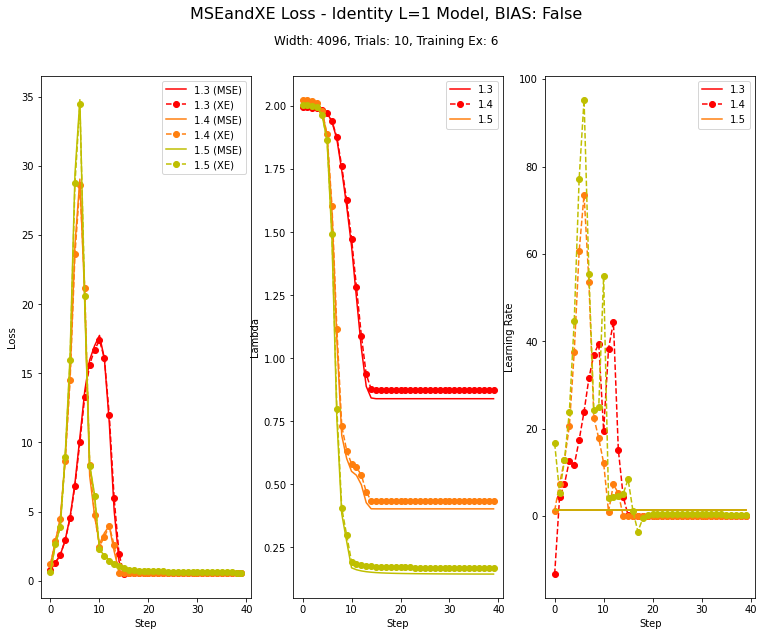

In [124]:
start = timeit.default_timer()

##### Network parameters #####
network_params = {
  'width': 2**12,
  'length': 1,
  'input_dim': 1,
  'output_dim': 1,
  'activation': 'Identity', # supports 'Identity', 'ReLU', 'Tanh'
  'bias': False,
}

##### Training parameters #####

# X = torch.tensor([[1.0]])
# y = torch.tensor([[0.0]])
X = torch.tensor([[1.1], [1.1], [1.0], [1.0], [0.9], [0.9]])
y = torch.tensor([1, 0, 1, 0, 1, 0])

train_params = {
  'trials': 10,  # average over this many training_trials
  'loss': 'MSE', # support 'MSE', 'XE'
  'batch_size': X.shape[0],

  'physical_time': False,
  'epochs': 40,
  'physical_time_cap': 1 * network_params['width'],
  'var_lr': False,

  'lr_vals': [1.3, 1.4, 1.5], #np.linspace(4, 30, 10), #[i+5 for i in range(12)],
  'n_train': X.shape[0],

  'w_const': False
}

##### Result parameters #####
result_params = {
  'plots': ['Loss', 'Lambda', 'LR'], # supports 'Loss', 'LR', 'Lambda', 'Dead_neuron_perc', 'Final_DNP', 'Initial_states', 
  # (cont.) 'f0_lam0_alive', 'Network_survival'
  'save_data': False,
  'file_name': 'sep_vs_nonsep/w1024_2in_x1e1-e_y01_e01_phases_200steps',
  'override': False,
}

if result_params['save_data'] and path.exists('data/' + file_name + '.png') and not result_params['override']:
    raise ValueError("File already exists!")

# Reshapes X and y and sends to device
X_device = X.view(X.shape[0], network_params['input_dim']).to(device)
if train_params['loss'] == 'MSE':
  y_device = y.view(y.shape[0], network_params['input_dim']).to(device)
elif train_params['loss'] == 'XE':
  y_device = y.view(y.shape[0]).to(device)
train_data = [X_device, y_device]

# Sets parameters to defaults if unspecified above
train_params, network_params, result_params = default_params(train_data, train_params, network_params, result_params)

#### Various Tests ####
# results = test_multiple_lrs(train_data, train_params, network_params, result_params)
# neuron_surivival(train_data, train_params, network_params, result_params)
compare_mse_and_xe([X, y], train_params, network_params, result_params)

stop = timeit.default_timer()
print('Total Run Time: ', stop - start)  